In [46]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
import joblib

# Load dataset
data_df = pd.read_csv('games.csv')
print("Dataset shape:", data_df.shape)
data_df.info()

Dataset shape: (20058, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memor

In [47]:
# Rename columns for easier reference
data_df.columns = [
    'Game_ID', 'Rated_(T/F)', 'Start_Time', 'End_Time', 
    'Number_of_Turns', 'Game_Status', 'Winner', 'Time_Increment',
    'White_ID', 'White_Rating', 'Black_ID',
    'Black_Rating', 'Moves',
    'Opening_Eco', 'Opening_Name', 'Opening_Ply'
]

In [48]:
# print("Columns in DataFrame: \n",data_df.columns)
# print("Info: \n",data_df.info)
# print("NA Values: \n",data_df.isna().sum())
# print("Null Values: \n",data_df.isnull().sum())

### Simplification of Data

In [49]:
# 1. Simplify Results
data_df['Result_Simplified'] = data_df['Winner'].map({'White': 'White Win', 'Black': 'Black Win', 'Draw': 'Draw'})

In [50]:
# 2. Calculate Elo Difference
data_df['Elo_Difference'] = data_df['White_Rating'] - data_df['Black_Rating']

In [51]:
# 3. Categorize Game Duration
def categorize_duration(duration):
    if duration < 300:  # Less than 5 minutes
        return 'Short'
    elif duration < 900:  # 5-15 minutes
        return 'Medium'
    else:
        return 'Long'

data_df['Duration_Category'] = data_df['End_Time'] - data_df['Start_Time']
data_df['Duration_Category'] = data_df['Duration_Category'].apply(categorize_duration)

In [52]:
# 4. Opening Analysis
data_df['Opening'] = data_df['Opening_Name']

In [53]:
# 5. Time per Move
data_df['Time_Per_Move'] = (data_df['End_Time'] - data_df['Start_Time']) / data_df['Number_of_Turns']

In [54]:
# 6. Elo Rating Tier
bins = [0, 1200, 1600, 2000, float('inf')]
labels = ['Beginner', 'Intermediate', 'Advanced', 'Master']
data_df['White_Rating_Tier'] = pd.cut(data_df['White_Rating'], bins=bins, labels=labels)
data_df['Black_Rating_Tier'] = pd.cut(data_df['Black_Rating'], bins=bins, labels=labels)


In [55]:
# Convert timestamps to datetime, handle errors, and fill missing values
data_df['Start_Time'] = pd.to_datetime(data_df['Start_Time'], unit='ms', errors='coerce').fillna(pd.Timestamp('1970-01-01'))
data_df['End_Time'] = pd.to_datetime(data_df['End_Time'], unit='ms', errors='coerce').fillna(pd.Timestamp('1970-01-01'))

# Calculate 'Game_Duration' in minutes and handle cases with zero duration
data_df['Game_Duration'] = (data_df['End_Time'] - data_df['Start_Time']).dt.total_seconds()/60
data_df.loc[data_df['Start_Time'] == data_df['End_Time'], 'Game_Duration'] = 1

# Remove rows with Game_Duration == 1
data_df = data_df[data_df['Game_Duration'] > 1]

# Remove rows where Game_Duration is divisible by 10
data_df = data_df[data_df['Game_Duration'] % 10 != 0]


In [56]:
# Average Time
data_df["Average Time"] = data_df["Time_Per_Move"] / data_df['Game_Duration']

In [57]:
# Drop specific columns
data_df = data_df.drop(['Start_Time', 'End_Time','White_ID','Black_ID','White_Rating', 'Black_Rating','Opening_Name',], axis=1)

In [58]:
data_df.columns

Index(['Game_ID', 'Rated_(T/F)', 'Number_of_Turns', 'Game_Status', 'Winner',
       'Time_Increment', 'Moves', 'Opening_Eco', 'Opening_Ply',
       'Result_Simplified', 'Elo_Difference', 'Duration_Category', 'Opening',
       'Time_Per_Move', 'White_Rating_Tier', 'Black_Rating_Tier',
       'Game_Duration', 'Average Time'],
      dtype='object')

C:\Users\Kshitish Pandit\AppData\Local\Temp\ipykernel_16432\2188236063.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_openings.values, y=top_openings.index, palette="Blues_d")


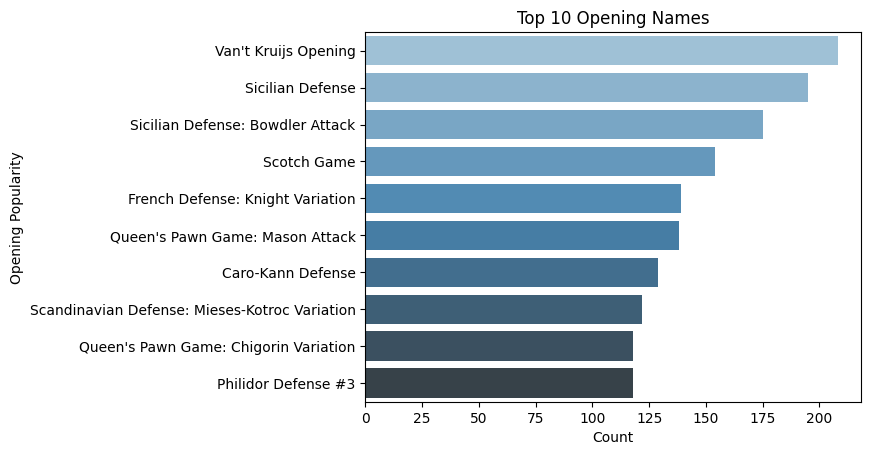

In [59]:
# Now, calculate the top 10 most frequent opening eco codes (or names)
top_openings = data_df['Opening'].value_counts().head(10)

# Create the bar plot for top openings
sns.barplot(x=top_openings.values, y=top_openings.index, palette="Blues_d")
plt.title("Top 10 Opening Names")
plt.xlabel("Count")
plt.ylabel("Opening Popularity")
plt.show()

In [60]:
data_df.columns

Index(['Game_ID', 'Rated_(T/F)', 'Number_of_Turns', 'Game_Status', 'Winner',
       'Time_Increment', 'Moves', 'Opening_Eco', 'Opening_Ply',
       'Result_Simplified', 'Elo_Difference', 'Duration_Category', 'Opening',
       'Time_Per_Move', 'White_Rating_Tier', 'Black_Rating_Tier',
       'Game_Duration', 'Average Time'],
      dtype='object')

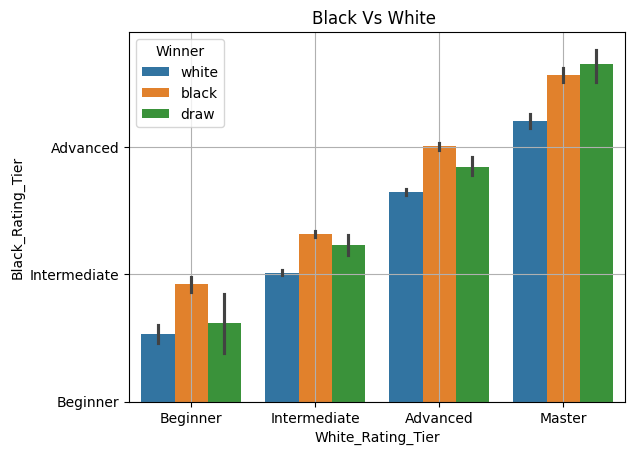

In [61]:
sns.barplot(data=data_df,x = "White_Rating_Tier", y = "Black_Rating_Tier", hue="Winner")
plt.title("Black Vs White ")
plt.grid(True)
plt.gca().invert_yaxis()

plt.show()

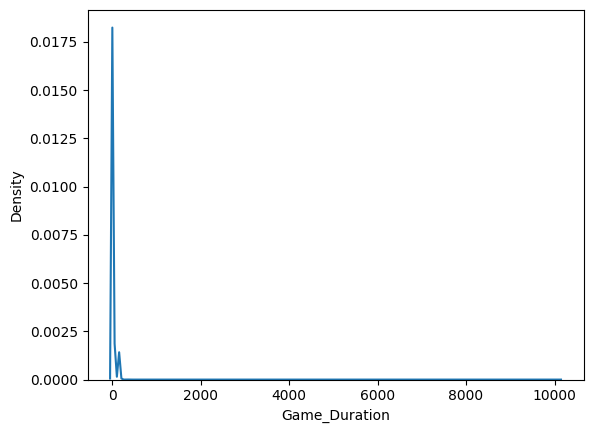

In [62]:
sns.kdeplot(data=data_df, x = 'Game_Duration')
plt.show()

In [63]:
data_df.to_csv("Data1.csv")